In [1]:
!pip install deepface

     |████████████████████████████████| 62 kB 509 kB/s 
     |████████████████████████████████| 2.3 MB 12.3 MB/s 


In [2]:
# Module / package imports
import cv2
import os
import random
import shutil
import zipfile
import tarfile
import requests
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt
import matplotlib.image   as mpimg
import matplotlib.patches as patches
import tensorflow         as tf

tf_version = int(tf.__version__.split(".")[0])

if tf_version == 2:
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    from tensorflow.keras.preprocessing import image
else:
    from keras.preprocessing import image

from PIL                     import Image
from io                      import BytesIO
from deepface                import DeepFace
from google.colab            import files
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay

# ==============================================================================

ROOT_DIR    = os.path.dirname(os.path.realpath("__file__"))
DATASET_DIR = os.path.join(ROOT_DIR, "dataset")

#                0    ,     1    ,      2      ,     3     ,      4      ,      5     ,     6    ,   7
BACKENDS = [  "opencv",     "ssd",       "dlib",    "mtcnn", "retinaface", "mediapipe"]
MODELS   = ["VGG-Face", "Facenet", "Facenet512", "OpenFace",   "DeepFace",    "DeepID", "ArcFace", "Dlib"]

if len(tf.config.list_physical_devices('GPU')) == 0:
  print('!!! WARNING !!!: No GPU found! This script might take longer\
  than expected if executed using only CPUs!')

# ==============================================================================

# Create directory function
def create_dir(dir_path):
  """
  Creates a directory at the specified directory path 'dir_path' IF it does not
  exist. Returns a status of 0 is the directory was successfully created and 
  returns a status of 1 if a directory already exists.

  Inputs:
    1. dir_path - directory path of new directory.
    
  Outputs:
    1. status - 0 to indicate success (directory creation) or 1 to indicate
       failure (directory already exists)
    
  Example call:
    status = create_dir("./this/is/a/directory/path")
  """
  # Create directory
  try:
    os.makedirs(dir_path)
    status = 0
  except FileExistsError:
    # Directory already exists
    status = 1

  return status

# ==============================================================================

def plot_sad_face(ax):
  """
  Plots a sad face in the axes provided.

  Input:
    1. ax - matplotlib axes

  Output:
    None (plots a sad face in the axes provided)

  Example call:
  fig, ax = subplots(1, 1)
  plot_sad_face(ax)

  Credits: bbengfort
  Repo: https://gist.github.com/bbengfort/dd9d8027a37f3a96c44323a8303520f0
  """

  ax.scatter([.5],[.5], c='#FFCC00', s=120000, label="face")
  ax.scatter([.35, .65], [.63, .63], c='k', s=1000, label="eyes")

  X = np.linspace(.3, .7, 100)
  Y = -2* (X-.5)**2 + 0.40

  ax.plot(X, Y, c='k', linewidth=8, label="smile")

  ax.set_xlim(0,1)
  ax.set_ylim(0,1)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.set_xticks([])
  ax.set_yticks([])

# ==============================================================================

def plot_FR_match(target, result, figsize=(6,6)):
  """
  Plots the first result of the face recognition (FR) match along with the
  target face provided. If no match is found, plots a sad face :(.

  Inputs:
    1. target - image path of the target image
    2. result - pandas dataframe with the result of the FR system.
    3. figsize - tuple containing the figure size in inches ([figsize=(6,6)])

  Output:
    None (plots the FR match)

  Example call:
    plot_FR_match(target, result, figsize=(6,6))
  """
  fig, axs = plt.subplots(1, 2, figsize=figsize)
  axs[0].imshow(mpimg.imread(target))
  axs[0].set_title("Target: {}".format(target.split("/")[-1][:-4]))

  if result.empty:
    # Plots a sad face if there is no match
    plot_sad_face(axs[1])
    axs[1].set_title("No match")
  else:
    # Plots the first result of the face recognition system
    fresult = result.iloc[0, 0]
    axs[1].imshow(mpimg.imread(fresult))
    axs[1].set_title("Result: {}".format(fresult.split("/")[-1][:-4]))

  txt="=" * 40
  plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center',
              fontsize=12)

# ==============================================================================


Directory  /root /.deepface created
Directory  /root /.deepface/weights created


# Create dataset structure

Creates the dataset directory structure:
  - dataset
    - gallery
      - image_001.jpg
      - ...
      - image_XXX.jpg
    - targets
      - image_001.jpg
      - ...
      - image_YYY.jpg

In [6]:
# Creates the dataset root directory, along with the gallery and targets
# subdirectories
if create_dir(DATASET_DIR):
  print(f"Dataset directory already exists!\n{DATASET_DIR}\n")

TARGETS_PATH = os.path.join(DATASET_DIR, "targets")
GALLERY_PATH = os.path.join(DATASET_DIR, "gallery")

if create_dir(TARGETS_PATH):
  print(f"Targets directory already exists!\n{TARGETS_PATH}\n")

if create_dir(GALLERY_PATH):
  print(f"Gallery directory already exists!\n{GALLERY_PATH}\n")


Dataset directory already exists!
/content/dataset

Targets directory already exists!
/content/dataset/targets

Gallery directory already exists!
/content/dataset/gallery



# Uploading images

Here you can upload images to the gallery (reference images) and target images to test the face recognition system. You can add image in batches. If you need to add images in different subdirectories, just choose all images in the first subdirectory, hit ok, then type in "n" and hit enter. Repeat these steps until all images are loaded. When you are done, just press any other key and hit enter.

In [7]:
print("Please upload references images. We recommend uploading 1 reference \
image for different people. Start out with a small number, i.e. 1-3 different \
people first.\n")

os.chdir(GALLERY_PATH)

while True:
  print("Upload image:")
  try:
    files.upload();
  except:
    break
  
  print("Press 'n' to upload another image.")
  if input().lower() != "n":
    break

print("Uploaded images:")
%ls

Please upload references images. We recommend uploading 1 reference image for different people. Start out with a small number, i.e. 1-3 different people first.

Upload image:


Saving Anthony_Hopkins_0001.jpg to Anthony_Hopkins_0001.jpg
Saving Diana_Krall_0001.jpg to Diana_Krall_0001.jpg
Saving Jose_Dirceu_0001.jpg to Jose_Dirceu_0001.jpg
Press 'n' to upload another image.

Uploaded images:

Anthony_Hopkins_0001.jpg  Diana_Krall_0001.jpg  Jose_Dirceu_0001.jpg


In [8]:
print("Please upload target images. These are images of faces that you want to \
run the face recognition on. We recommend uploading a few target images \
including people in and not in the references.\n")
os.chdir(TARGETS_PATH)

while True:
  print("Upload image:")
  try:
    files.upload();
  except:
    break
  
  print("Press 'n' to upload another image.")
  if input().lower() != "n":
    break

print("Uploaded images:")
%ls

Please upload target images. These are images of faces that you want to run the face recognition on. We recommend uploading a few target images including people in and not in the references.

Upload image:


Saving Anthony_Hopkins_0002.jpg to Anthony_Hopkins_0002.jpg
Saving Diana_Krall_0002.jpg to Diana_Krall_0002.jpg
Saving Diana_Krall_0003.jpg to Diana_Krall_0003.jpg
Saving Diana_Krall_0004.jpg to Diana_Krall_0004.jpg
Saving Diana_Krall_0005.jpg to Diana_Krall_0005.jpg
Saving Diana_Krall_0006.jpg to Diana_Krall_0006.jpg
Saving Frank_Stallone_0002.jpg to Frank_Stallone_0002.jpg
Saving Jose_Dirceu_0002.jpg to Jose_Dirceu_0002.jpg
Saving Lee_Chang-dong_0001.jpg to Lee_Chang-dong_0001.jpg
Press 'n' to upload another image.

Uploaded images:
Anthony_Hopkins_0002.jpg  Diana_Krall_0004.jpg  Frank_Stallone_0002.jpg
Diana_Krall_0002.jpg      Diana_Krall_0005.jpg  Jose_Dirceu_0002.jpg
Diana_Krall_0003.jpg      Diana_Krall_0006.jpg  Lee_Chang-dong_0001.jpg


# Face recognition system results

This section runs the face recognition system and outputs all the results. To keep this demo simple, only the first result of the face recognition system is shown per target image (this is irrelevant if you have uploaded 1 image per different person to the gallery).

In [17]:
# Define the face detector and verifier models
FACE_DETECTOR = BACKENDS[4]
FACE_VERIFIER = MODELS[6]

# Obtains all targets (all images in the 'targets' subdirectory)
all_targets = [os.path.join(TARGETS_PATH, target) for target \
               in os.listdir(TARGETS_PATH)]

# Runs all targets through the face recognition system
results = DeepFace.find(img_path = all_targets,
                        db_path = GALLERY_PATH,
                        model_name = FACE_VERIFIER,
                        detector_backend = FACE_DETECTOR,
                        distance_metric = "euclidean_l2",
                        prog_bar = False) # dunno why prog_bar is inverted

There are  3  representations found in  representations_arcface.pkl


Analyzing: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]

find function lasts  3.3054187297821045  seconds


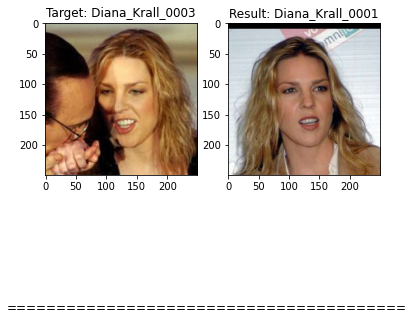

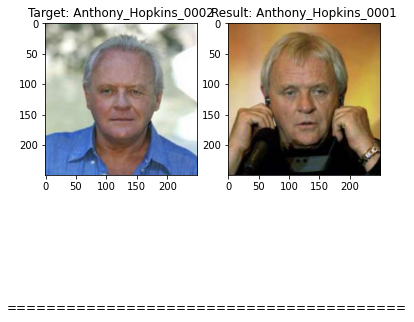

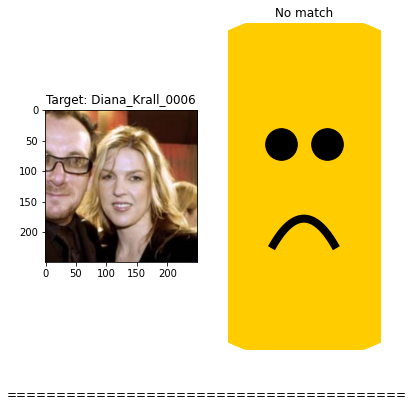

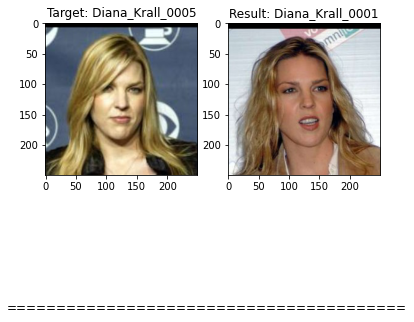

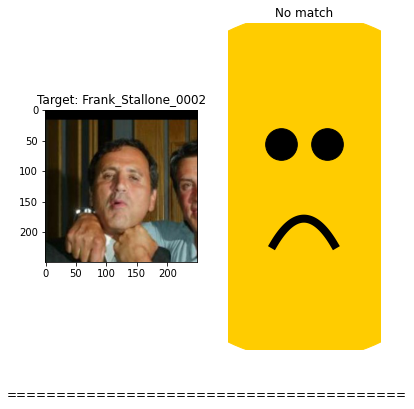

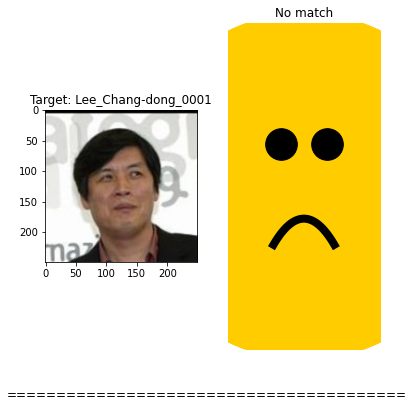

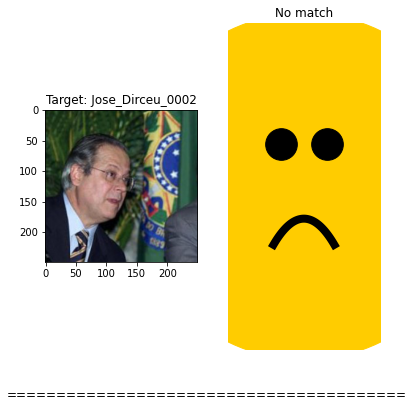

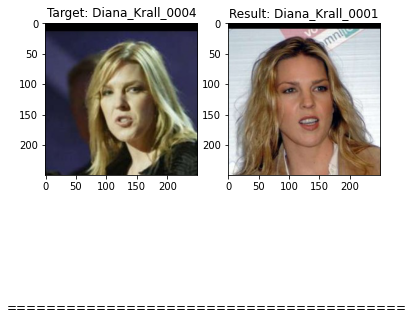

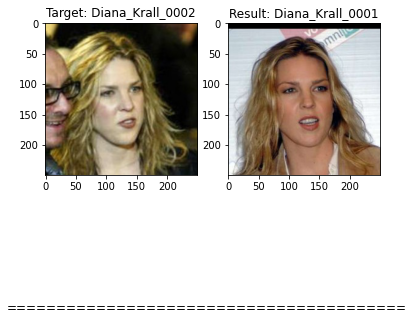

In [18]:
for result, target in zip(results, all_targets):
  plot_FR_match(target, result)